In [1]:
import collections
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torchvision
from torch.cuda.amp.autocast_mode import autocast
from torch.cuda.amp.grad_scaler import GradScaler
from PIL import Image

C:\Users\BBA\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [2]:
dpack = 'wgroup3'

with open(f'data/{dpack}', 'rb') as f:
    audio_data = pickle.load(f)

with open(f'data/mcm140', 'rb') as f:
    mmtrx = pickle.load(f).astype(np.float32)

audio_data = [((torch.tensor(x[0], dtype=torch.float32) - mmtrx).unsqueeze(0), x[1]) for x in audio_data]
counts = collections.Counter([x[1] for x in audio_data])
total = np.sum([x for x in counts.values()])
lblwgts = [counts[x] / total for x in range(19)]
lblwgts = [((((1/19) / x) + 1/19) / 2) + 0.3678 for x in lblwgts]
blur = torchvision.transforms.GaussianBlur(3, sigma=(0.1, 2.0))
erase = torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.8, 1.2), value=0, inplace=False)
crop = torchvision.transforms.RandomResizedCrop((140, 128), scale=(0.84, 1.0))
affine = torchvision.transforms.RandomAffine(0, translate=(0.2, 0), scale=(0.86, 1.14), shear=None, fill=0)
invert = torchvision.transforms.RandomInvert()
transforms = [blur, erase, crop, affine, invert]


In [2]:
dpack = 'rand140'

with open(f'data/{dpack}', 'rb') as f:
    audio_data = pickle.load(f)

(140, 128)


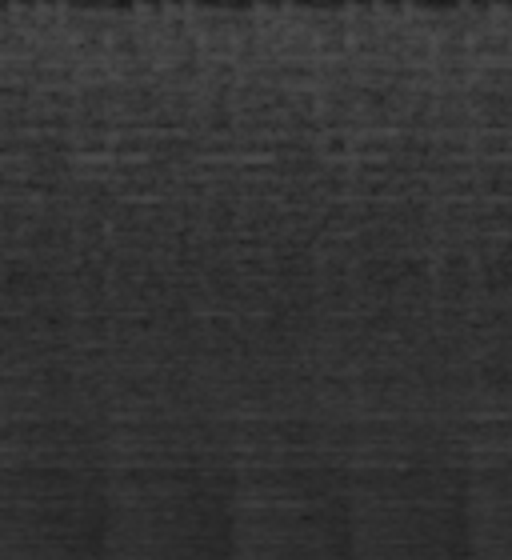

In [7]:
check = audio_data[140][0]
print(check.shape)
Image.fromarray(check).resize((check.shape[1] * 4, check.shape[0] * 4))

In [18]:

def group_predict(adata, model):
    predictions = []
    model.to('cuda')
    with torch.no_grad():
        for song in adata:
            frames = [(torch.tensor(frame, dtype=torch.float32) - mmtrx).unsqueeze(0).unsqueeze(0) for frame in song[0]]
            results = []
            for frame in frames:
                frame.to('cuda')
                results.append(torch.nn.functional.softmax(*model(frame), dim=0).tolist())
            #results = [w for w in results if np.max(w) > np.max(results) * 0.333]
            results = np.array(results)
            best = results.argmax()
            while best > 18:
                best -= 18
            scores = [round(sum(w), 4) for w in  np.array(results).T]
            predictions.append((song[1], scores.index(np.max(scores)), best))
    model.to('cpu')
    return predictions

def aug_imgs(img_data):
    np.random.shuffle(img_data)
    aug_count = int(len(img_data) * 0.3678)
    change = img_data[:aug_count]
    final = img_data[aug_count:]
    change = [((x[0] + 55).to(torch.uint8), x[1]) for x in change]
    new_pack = []
    start = time.time()
    i = 0
    for item in change:
        label = item[1]
        img = np.random.choice(transforms)(item[0])
        if img.size() != (140, 128):
            img = torchvision.transforms.functional.resize(img, (140, 128))
        new_pack.append((img, label))
        i += 1
        if i in range(0, 150000, 5000):
            print(i / (time.time() - start))
    new_pack = [(x[0].to(torch.float32) - 55, x[1]) for x in new_pack]
    final.extend(new_pack)
    np.random.shuffle(final)
    return final

class Mini3(nn.Module):

    def __init__(self, ftrs):
        super(Mini3, self).__init__()
        self.dcnv = nn.Conv2d(ftrs, ftrs // 2, 1)
        self.cnv = nn.Conv2d(ftrs // 2, ftrs // 2, 3, 1, 1, bias=False)
        self.ucnv = nn.Conv2d(ftrs // 2, ftrs, 1)
        self.nrm = nn.BatchNorm2d(ftrs // 2)
        self.act = nn.ELU()

    def forward(self, x):
        x = self.act(self.dcnv(x))
        x = self.act(self.nrm(self.cnv(x)))
        x = self.act(self.ucnv(x))
        return x

class ReStep(nn.Module):

    def __init__(self, ftrs, poolks, final=False):
        super(ReStep, self).__init__()
        self.cnv1 = Mini3(ftrs)
        self.cnv2 = Mini3(ftrs)
        self.cnv3 = Mini3(ftrs)
        self.dscale = nn.Conv2d(ftrs, ftrs, 1, poolks)
        if final:
            self.uscale = nn.Conv2d(ftrs, ftrs, 1, 1)
        else:
            self.uscale = nn.Conv2d(ftrs, ftrs * 2, 1, 1)
        self.inrm = nn.BatchNorm2d(ftrs)
        self.mxpool = nn.MaxPool2d(poolks, poolks)
        self.iact = nn.ELU()

    def forward(self, x):
        res = x
        x = self.cnv1(x)
        x = self.cnv2(x)
        x = self.mxpool(x)
        x = self.iact(self.inrm(torch.add(x, self.dscale(res))))
        res = x
        x = self.cnv3(x)
        x = self.iact(self.inrm(torch.add(x, res)))
        x = self.iact(self.uscale(x))
        return x

class FeatureExtractor(nn.Module):

    def __init__(self, step_1_ftrs: int, step_2_ftrs: int, step_3_ftrs: int, step_4_ftrs: int):
        torch.manual_seed(1024)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        super(FeatureExtractor, self).__init__()
        self.final_ftrs = step_4_ftrs // 2
        self.ecnv1 = nn.Conv2d(1, step_1_ftrs, 3, 1, 1)
        self.ecnv2 = nn.Conv2d(step_1_ftrs, step_1_ftrs, 3, 1, 1)
        self.ecnv3 = nn.Conv2d(step_1_ftrs, step_1_ftrs, 3, 1, 1)
        self.fcnv1 = nn.Conv2d(step_4_ftrs, self.final_ftrs, 3, 1, 1, bias=False)
        self.fcnv2 = nn.Conv2d(step_4_ftrs, self.final_ftrs, 3, 1, 1, bias=False)
        self.fcnv3 = nn.Conv2d(step_4_ftrs, self.final_ftrs, 3, 1, 1, bias=False)
        self.nrm1 = nn.BatchNorm2d(self.final_ftrs)
        self.nrm2 = nn.BatchNorm2d(self.final_ftrs)
        self.nrm3 = nn.BatchNorm2d(self.final_ftrs)
        self.lstep1 = ReStep(step_1_ftrs, (1, 2))
        self.lstep2 = ReStep(step_2_ftrs, (1, 2))
        self.lstep3 = ReStep(step_3_ftrs, 2, True)
        self.lstep4 = ReStep(step_4_ftrs, 2, True)
        self.mstep1 = ReStep(step_1_ftrs, (1, 2))
        self.mstep2 = ReStep(step_2_ftrs, 2)
        self.mstep3 = ReStep(step_3_ftrs, 2, True)
        self.mstep4 = ReStep(step_4_ftrs, 2, True)
        self.hstep1 = ReStep(step_1_ftrs, 2)
        self.hstep2 = ReStep(step_2_ftrs, 2)
        self.hstep3 = ReStep(step_3_ftrs, 2, True)
        self.hstep4 = ReStep(step_4_ftrs, 2, True)
        self.flin = nn.Linear(self.final_ftrs * 9 * 3, self.final_ftrs)
        self.flin2 = nn.Linear(self.final_ftrs, 19)
        self.act = nn.ELU()
        self.flat = nn.Flatten()
        self.fmxpool = nn.AdaptiveAvgPool2d(3)
        self.drop = nn.Dropout2d(0.1)

    def forward(self, x):
        x = self.act(self.ecnv1(x))
        x = self.act(self.ecnv2(x))
        x = self.act(self.ecnv3(x))
        x = self.drop(x)
        lows = x[:,:, :16, :]
        mids = x[:,:, 14:62, :]
        highs = x[:,:, 60:, :]
        for i, step in enumerate([
                (self.lstep1, self.mstep1, self.hstep1),
                (self.lstep2, self.mstep2, self.hstep2),
                (self.lstep3, self.mstep3, self.hstep3),
                (self.lstep4, self.mstep4, self.hstep4)
            ]):
            lows = step[0](lows)
            mids = step[1](mids)
            highs = step[2](highs)
            if i >= 2:
                lows = self.drop(lows)
                mids = self.drop(mids)
                highs = self.drop(highs)
        lows = self.act(self.nrm1(self.fcnv1(lows)))
        mids = self.act(self.nrm2(self.fcnv2(mids)))
        highs = self.act(self.nrm3(self.fcnv3(highs)))
        lows = self.flat(self.fmxpool(lows))
        mids = self.flat(self.fmxpool(mids))
        highs = self.flat(self.fmxpool(highs))
        x = torch.cat((lows, mids, highs), 1)
        x = self.flin2(self.act(self.flin(x)))
        return x

class Trainer:

    def __init__(self, model: nn.Module, learning_rate: float, weight_decay: float, label_weights, save_threshold):
        self.gpu = torch.device('cuda')
        self.model = model.to(self.gpu)
        self.save_threshold = save_threshold
        self.optimizer = torch.optim.NAdam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.loss_function = nn.CrossEntropyLoss(weight=torch.tensor(label_weights, dtype=torch.float32))
        #self.loss_function = nn.CrossEntropyLoss()
        self.scaler = GradScaler(enabled=True)

    def split_data(self, tdata, ratio, splits):
        np.random.shuffle(tdata)
        vdata = []
        for x in counts.items():
            gcounter = 0
            i = 0
            while gcounter < int(x[1] * ratio):
                if tdata[i][1] == x[0]:
                    vdata.append(tdata.pop(i))
                    gcounter += 1
                i += 1
        np.random.shuffle(tdata)
        np.random.shuffle(vdata)
        tdata = [tdata[(x - 1) * int(len(tdata) / splits) : x * int(len(tdata) / splits)] for x in range(1, splits + 1)]
        return tdata, vdata

    def _train(self, dataset):
        total_loss = 0
        for x in dataset:
            with autocast(enabled=True):
                data, labels = x[0].to(self.gpu), x[1].to(self.gpu)
                results = self.model(data)
                loss = self.loss_function(results, labels)
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            total_loss += loss.item()
            self.optimizer.zero_grad()
        return total_loss / len(dataset)

    def _validate(self, dataset):
        total_loss = 0
        accuracy = 0
        with torch.no_grad():
            for x in dataset:
                correct = 0
                data, labels = x[0].to(self.gpu), x[1].to(self.gpu)
                results = self.model(data)
                for i, w in enumerate([torch.nn.functional.softmax(y, dim=0).argmax() for y in results]):
                    if w == labels[i]:
                        correct += 1
                accuracy += correct / self.batch_size
                total_loss += self.loss_function(results, labels).item()
        return total_loss / len(dataset), accuracy / len(dataset)

    def train_model(self, dataset: np.ndarray, target_epochs: int, batch_size: int, ratio: float, model_name: str, val: bool, splits: int):
        self.batch_size = batch_size
        samples = len(dataset)
        train_data, val_data = self.split_data(dataset, ratio, splits)
        for ep in range(target_epochs):
            for i, group in enumerate(train_data):
                if ep in [3, 4, 5]:
                    aug_data = aug_imgs(group.copy())
                    tdata = iter(torch.utils.data.DataLoader(aug_data, batch_size=self.batch_size))
                else:
                    tdata = iter(torch.utils.data.DataLoader(group, batch_size=self.batch_size))
                self.model.train(True)
                train_loss = self._train(tdata)
                if not val:
                    print(f'Status at batch {int((i+1) * int(samples * (1 - ratio)) / splits / self.batch_size)},\tTLoss: {round(float(train_loss), 5)} TAccuracy {round(2.7182818**-float(train_loss) * 100, 5)}%')
                if val:
                    self.model.train(False)
                    vdata = iter(torch.utils.data.DataLoader(val_data, batch_size=self.batch_size))
                    val_loss, val_acc = self._validate(vdata)
                    print(f'Status at batch {int((i+1) * int(samples * (1 - ratio)) / splits / self.batch_size)},\tTLoss: {round(float(train_loss), 5)}\tTAccuracy {round(2.7182818**-float(train_loss) * 100, 5)}%\tVLoss: {round(float(val_loss), 5)}\tVGAccuracy {round(float(val_acc) * 100, 5)}%\tVPAccuracy {round(2.7182818**-float(val_loss) * 100, 5)}%')
                    if val_loss < self.save_threshold:
                        self.save_threshold = val_loss
                        torch.save(self.model.state_dict(), f'models/{model_name}')
        self.model = self.model.cpu()
        del dataset
        torch.cuda.empty_cache()


In [3]:
av_model = FeatureExtractor(32, 64, 128, 128)
av_model.load_state_dict(torch.load('models/mscls_3'))

<All keys matched successfully>

In [ ]:
trainer = Trainer(av_model, 1e-4, 1e-5, lblwgts, 1.26268)
trainer.train_model(audio_data, 6, 32, 0.06, 'mscls_3', True, 2)

In [6]:
#torch.save(av_model.state_dict(), 'models/mscls_31')

In [ ]:
print(sum(x.numel() for x in av_model.parameters() if x.requires_grad))

In [19]:
dpack = 'tgroup03'
with open(f'data/{dpack}', 'rb') as f:
    tdata = pickle.load(f)

with open(f'meanmtrx', 'rb') as f:
    mmtrx = torch.tensor(pickle.load(f), dtype=torch.float32)

predictions = group_predict(tdata, av_model)
real_l = [14, 14, 3, 3, 3, 6, 6, 7, 7, 0, 0, 0, 10, 10, 10, 2, 2, 2, 8, 8, 8, 5, 5, 5, 4, 4, 4, 1, 1, 1, 9, 9, 12, 12, 15, 15, 16, 16, 17, 17, 13, 13, 11, 11, 18, 18]
score = 0
for i, x in enumerate(predictions):
    print(x, real_l[i])
    if x[1] == real_l[i]:
        score += 1
print(score)


('002366.ogg', 8, 10) 14
('002376.ogg', 8, 5) 14
('005188.ogg', 3, 8) 3
('005190.ogg', 2, 2) 3
('005191.ogg', 5, 11) 3
('005879.ogg', 0, 9) 6
('005880.ogg', 6, 8) 6
('006003.ogg', 3, 3) 7
('006005.ogg', 14, 15) 7
('007978.ogg', 0, 6) 0
('007979.ogg', 0, 5) 0
('007980.ogg', 0, 5) 0
('007989.ogg', 0, 3) 10
('007990.ogg', 0, 4) 10
('007991.ogg', 10, 15) 10
('008341.ogg', 2, 5) 2
('008342.ogg', 2, 5) 2
('008343.ogg', 2, 5) 2
('008405.ogg', 8, 7) 8
('008406.ogg', 0, 12) 8
('008419.ogg', 3, 5) 8
('008564.ogg', 1, 7) 5
('008565.ogg', 0, 4) 5
('008566.ogg', 1, 7) 5
('008671.ogg', 0, 0) 4
('008672.ogg', 0, 3) 4
('008673.ogg', 4, 6) 4
('008875.ogg', 1, 2) 1
('008876.ogg', 2, 6) 1
('008877.ogg', 2, 3) 1
('009195.ogg', 8, 12) 9
('009198.ogg', 8, 5) 9
('010482.ogg', 3, 3) 12
('010501.ogg', 3, 15) 12
('012465.ogg', 1, 15) 15
('012519.ogg', 0, 15) 15
('012818.ogg', 3, 3) 16
('012906.ogg', 3, 4) 16
('014021.ogg', 1, 3) 17
('014060.ogg', 17, 17) 17
('016978.ogg', 0, 5) 13
('016986.ogg', 13, 14) 13
('01

In [ ]:
Image.fromarray(tdata[101][0][0]).resize((500, 500))

In [ ]:
dpack = 'tgroup1'
with open(f'data/{dpack}', 'rb') as f:
    tdata = pickle.load(f)

predictions = group_predict(tdata, av_model)
filename = 'noshuf'

with open(f'predictions/{filename}.csv', 'wt') as f:
    f.writelines(['song_id,genre_id\n'])
    f.writelines([f'{x[0].lstrip("0").rstrip(".ogg")},{x[1]}\n' for x in predictions])
    f.writelines(['24013,0\n', '22612,1\n'])